<a href="https://colab.research.google.com/github/Noah-Gallego/cardiac_challenge/blob/main/task2ArrhythmiaMultiClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting started with Task 2

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model

# Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## MIT-BIH  Arrhythmia Dataset

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the mitbih_train is :  (21892, 188)
The shape of the mitbih_test is :  (87554, 188)
The last time value is :  1488.0


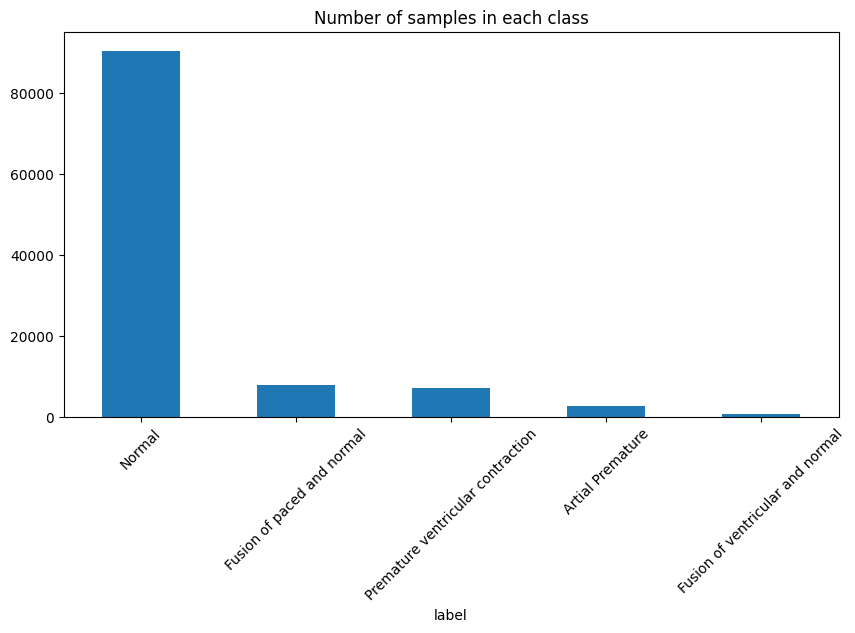

In [3]:
df_mitbih_train = pd.read_csv("/content/drive/My Drive/ecg_dataset/mitbih_test.csv", header = None)
df_mitbih_test = pd.read_csv("/content/drive/My Drive/ecg_dataset/mitbih_train.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

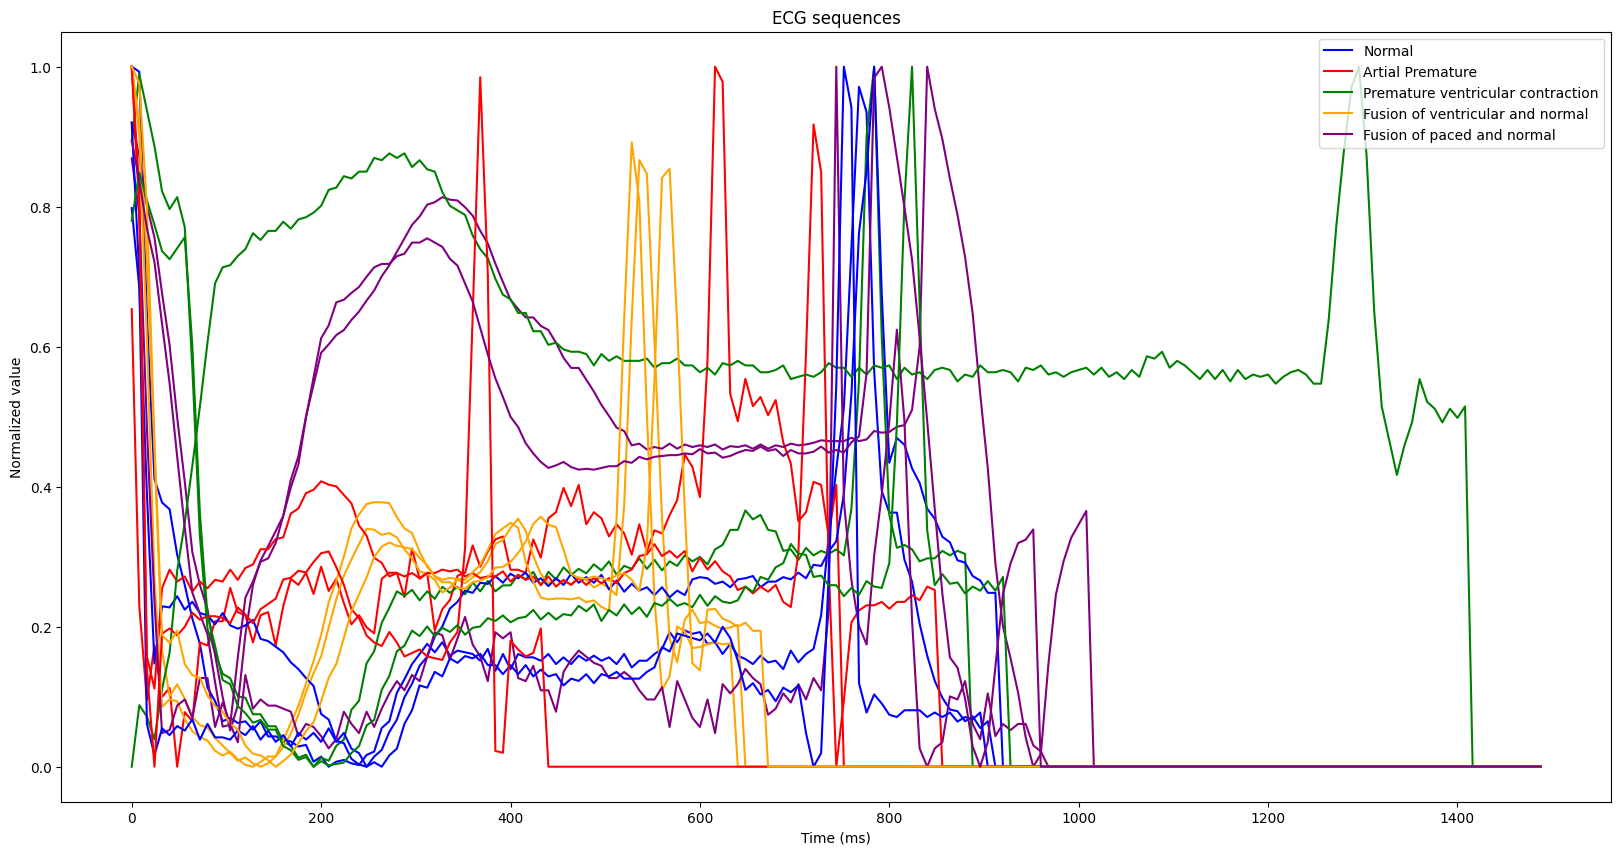

In [4]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [5]:
df_mitbih.head()

,0.0,8.0,16.0,24.0,32.0,40.0,48.0,56.0,64.0,72.0,...,1424.0,1432.0,1440.0,1448.0,1456.0,1464.0,1472.0,1480.0,1488.0,label
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# 1D CNN To Recognize Arrythmias

# Set up Data
train_data = df_mitbih_train
test_data = df_mitbih_test
print("The shape of the mitbih_train is: ", train_data.shape)
print("The shape of the mitbih_test is: ", test_data.shape)

# Set up Training and Test Data Split
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

# Reshape to Prepare for the CNN
signal_length = X_train.shape[1]
X_train = X_train.reshape((X_train.shape[0], signal_length, 1))
X_test = X_test.reshape((X_test.shape[0], signal_length, 1))

print("The shape of the X_train is: ", X_train.shape)
print("The shape of the X_test is: ", X_test.shape)
print("The shape of the y_train is: ", y_train.shape)
print("The shape of the y_test is: ", y_test.shape)

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

The shape of the mitbih_train is:  (21892, 188)
The shape of the mitbih_test is:  (87554, 188)
The shape of the X_train is:  (21892, 187, 1)
The shape of the X_test is:  (87554, 187, 1)
The shape of the y_train is:  (21892,)
The shape of the y_test is:  (87554,)


In [7]:
# Build the Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(signal_length, 1), name = 'first_conv'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu', name = 'second_conv'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Conv1D(filters = 256, kernel_size = 10, activation = 'relu', name='last_conv'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=5, activation='softmax')) # 5 classes for N, S, V, F, Q

# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_conv (Conv1D)         (None, 185, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 92, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 92, 64)            0         
                                                                 
 second_conv (Conv1D)        (None, 88, 128)           41088     
                                                                 
 batch_normalization (Batch  (None, 88, 128)           512       
 Normalization)                                                  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 128)           0

Epoch 1/5
685/685 [==============================] - 161s 227ms/step - loss: 0.3846 - accuracy: 0.9001 - val_loss: 0.1966 - val_accuracy: 0.9420
Epoch 2/5
685/685 [==============================] - 165s 241ms/step - loss: 0.1994 - accuracy: 0.9464 - val_loss: 0.1450 - val_accuracy: 0.9604
Epoch 3/5
685/685 [==============================] - 162s 237ms/step - loss: 0.1521 - accuracy: 0.9599 - val_loss: 0.1669 - val_accuracy: 0.9625
Epoch 4/5
685/685 [==============================] - 162s 236ms/step - loss: 0.1424 - accuracy: 0.9619 - val_loss: 0.1208 - val_accuracy: 0.9691
Epoch 5/5
2737/2737 [==============================] - 76s 28ms/step - loss: 0.1203 - accuracy: 0.9694
Loss:  0.12028750777244568
Accuracy:  0.969413161277771


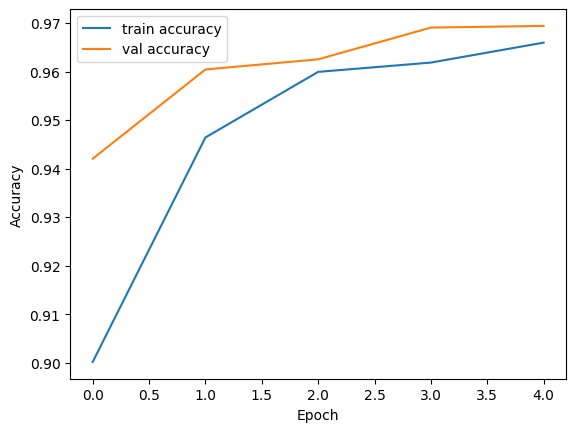

In [8]:
# Train the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Generating GradCAM for layer: last_conv
1/1 [==============================] - 0s 47ms/step
Generating GradCAM for layer: last_conv
1/1 [==============================] - 0s 41ms/step
Classification: Normal
Prediction: Normal
Confidence: 0.9996426105499268


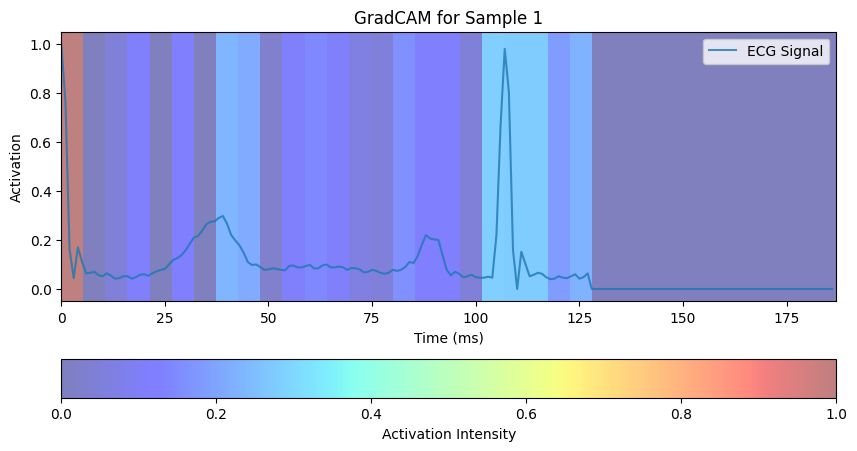

In [23]:
import tensorflow as tf
import matplotlib.cm as cm
import random

def grad_cam(model, layer_name, data, pred_index):
    # Takes original model's input and ouputs both activations of a specified layer
    # Allows us to compute gradients with respect to a desired layer
    grad_model = Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    print("Generating GradCAM for layer:", layer_name)

    # Compute gradients with respect to the desired layer
    with tf.GradientTape() as tape:
        # Forward pass the input
        conv_outputs, predictions = grad_model(data)
        # Compute the Loss
        loss = predictions[:, pred_index]

    # Compute the gradients
    grads = tape.gradient(loss, conv_outputs)
    # Average the gradients
    pooled_grads = tf.reduce_mean(grads, axis=0)

    # Get the activations
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def plot_gradcam(ecg_data, cam, prediction, class_names, title='GradCAM'):
    # Plot the GradCAM
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(ecg_data.flatten(), alpha=0.8, label='ECG Signal')

    # Add the GradCAM heatmap to plot of ECG
    cax = ax.imshow(np.expand_dims(cam, axis=0), cmap='jet', aspect='auto', alpha=0.5, extent=[0, len(ecg_data.flatten()), ax.get_ylim()[0], ax.get_ylim()[1]])
    fig.colorbar(cax, ax=ax, orientation='horizontal', label='Activation Intensity')
    ax.set_title(title)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Activation')
    ax.legend()

    # Add Classification & Prediction with Actual
    text = f'Classification: {class_names[np.argmax(prediction)]}\nPrediction: {class_names[np.argmax(y_test[sample_index])]}\nConfidence: {np.max(prediction)}'
    print(text)

    plt.show()

# Example usage on a test sample
sample_index = random.randint(0, X_test.shape[0])
sample_data = X_test[sample_index:sample_index + 1]

# Class Index
class_index = np.argmax(y_test[sample_index])

# Get GradCAM for the specified layer
layer_name = 'last_conv'
cam = grad_cam(model, layer_name, sample_data, class_index)

# Get the model prediction
prediction = model.predict(sample_data)

# Class names
class_names = list(id_to_label.values())

# Evaluate multiple samples with GradCAM
for i in range(1):
    sample_index = random.randint(0, X_test.shape[0] - 1)
    sample_data = X_test[sample_index:sample_index + 1]
    class_index = np.argmax(y_test[sample_index])
    cam = grad_cam(model, layer_name, sample_data, class_index)
    prediction = model.predict(sample_data)
    plot_gradcam(sample_data[0], cam, prediction, class_names, title=f'GradCAM for Sample {i + 1}')